# Project 7

- [Report](https://docs.google.com/document/d/1pSs_wpHYjo1OZ9z9QwRaCo_tz4DWXqKcrAWFAfhqMJg/edit?usp=sharing)
- [Slides](https://docs.google.com/presentation/d/1DMBQFvKbaLcGgou52KNbLoPdnhCPeLiOwgPv8jg1U-E/edit?usp=sharing)
- [Dataset](https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset)

## Setup

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import re
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import random
from sklearn.tree import export_graphviz
from IPython.display import SVG
# from graphviz import Source
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

## Exploring/Cleaning Data

### Collect Utah and Colorado housing data

In [4]:
df = pd.read_csv('realtor-data.csv')
df = df[df['state'].isin(['Utah', 'Colorado'])]
df = df.dropna()
print(f'This dataset includes houses sold as recently as {pd.to_datetime(df["prev_sold_date"]).max().date()}')
# df = df.drop(df[df.status == 'sold'].index)
df = df.reset_index(drop=True)
df

This dataset includes houses sold as recently as 2022-06-10


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,886.0,for_sale,489900.0,3.0,3.0,0.05,869665.0,Centennial,Colorado,80122.0,2376.0,2002-09-09
1,79200.0,for_sale,300000.0,3.0,3.0,0.16,1218508.0,Burlington,Colorado,80807.0,1920.0,2018-05-15
2,86788.0,for_sale,96500.0,2.0,1.0,0.16,555775.0,Burlington,Colorado,80807.0,816.0,2013-02-22
3,86788.0,for_sale,129500.0,2.0,1.0,0.24,1103130.0,Burlington,Colorado,80807.0,1466.0,1990-04-04
4,86397.0,for_sale,155000.0,2.0,2.0,0.14,1383743.0,Wray,Colorado,80758.0,2126.0,2014-06-12
...,...,...,...,...,...,...,...,...,...,...,...,...
19360,33714.0,sold,409000.0,3.0,2.0,0.22,422210.0,Kanab,Utah,84741.0,1845.0,2021-12-30
19361,33714.0,sold,330000.0,3.0,2.0,0.21,422448.0,Kanab,Utah,84741.0,1254.0,2021-12-23
19362,33714.0,sold,390800.0,3.0,3.0,0.53,435240.0,Kanab,Utah,84741.0,1433.0,2021-12-03
19363,109914.0,sold,525000.0,3.0,3.0,0.99,80628.0,Toquerville,Utah,84774.0,1661.0,2021-11-12


### Ensure that the two states have similar data to each other and remove outliers

In [5]:
display(df.describe())
display(df[df.state == 'Utah'].describe())
display(df[df.state == 'Colorado'].describe())

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,19365.000000,1.936500e+04,19365.000000,19365.000000,19365.000000,1.936500e+04,19365.000000,19365.000000
mean,58091.414253,8.202878e+05,3.687529,2.911800,3.959148,9.550237e+05,81336.669455,2688.779861
std,30580.940974,1.186134e+06,1.422447,1.348171,140.980685,5.271444e+05,1552.075957,1566.834990
min,52.000000,1.200000e+04,1.000000,1.000000,0.000000,4.280000e+03,80002.000000,288.000000
25%,31049.000000,4.300000e+05,3.000000,2.000000,0.140000,4.964620e+05,80234.000000,1670.000000
50%,57414.000000,5.650000e+05,4.000000,3.000000,0.180000,9.708640e+05,80601.000000,2368.000000
75%,81492.000000,7.990000e+05,4.000000,3.000000,0.300000,1.413672e+06,81507.000000,3345.000000
max,110072.000000,4.250000e+07,96.000000,56.000000,13521.000000,1.951788e+06,84790.000000,40381.000000


,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,4146.000000,4.146000e+03,4146.000000,4146.000000,4146.000000,4.146000e+03,4146.000000,4146.000000
mean,54236.147371,8.629224e+05,4.097202,3.032562,0.434267,9.619025e+05,84208.573565,2761.357694
std,30426.854593,1.091317e+06,2.167187,1.633235,1.830078,5.251221e+05,244.433023,1813.540357
min,633.000000,1.200000e+04,1.000000,1.000000,0.010000,6.586000e+03,84003.000000,348.000000
25%,31718.000000,4.400000e+05,3.000000,2.000000,0.110000,4.808232e+05,84044.000000,1719.000000
50%,51909.000000,5.750000e+05,4.000000,3.000000,0.190000,9.926450e+05,84096.000000,2342.000000
75%,82009.000000,8.250000e+05,5.000000,4.000000,0.290000,1.415766e+06,84335.000000,3364.500000
max,110072.000000,2.995000e+07,96.000000,56.000000,60.000000,1.836385e+06,84790.000000,40381.000000


,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,15219.000000,1.521900e+04,15219.000000,15219.000000,15219.000000,1.521900e+04,15219.000000,15219.000000
mean,59141.676194,8.086732e+05,3.575925,2.878901,4.919405,9.531498e+05,80554.297786,2669.008016
std,30539.538744,1.210451e+06,1.112275,1.257435,159.013334,5.276956e+05,435.625047,1492.031617
min,52.000000,1.390000e+04,1.000000,1.000000,0.000000,4.280000e+03,80002.000000,288.000000
25%,30698.000000,4.300000e+05,3.000000,2.000000,0.140000,4.991615e+05,80209.000000,1655.500000
50%,60885.000000,5.649500e+05,3.000000,3.000000,0.180000,9.658580e+05,80524.000000,2376.000000
75%,81492.000000,7.950000e+05,4.000000,3.000000,0.300000,1.412800e+06,80816.000000,3334.000000
max,110057.000000,4.250000e+07,22.000000,24.000000,13521.000000,1.951788e+06,81658.000000,28715.000000


In [6]:
outliers = df[df.price > df.price.mean() + 2 * df.price.std()]
outliers

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
977,52952.0,for_sale,3500000.0,4.0,5.0,13.08,351105.0,Arvada,Colorado,80005.0,3340.0,2015-01-20
1001,101888.0,for_sale,3500000.0,3.0,2.0,6.35,98326.0,Arvada,Colorado,80005.0,2244.0,2020-08-24
1532,62898.0,for_sale,4500000.0,5.0,7.0,0.73,833022.0,Denver,Colorado,80209.0,7831.0,2012-03-28
1550,55730.0,for_sale,4000000.0,14.0,15.0,0.24,679685.0,Denver,Colorado,80205.0,9102.0,1992-09-09
1565,53946.0,for_sale,5495000.0,6.0,9.0,2.50,1375018.0,Greenwood Village,Colorado,80121.0,10169.0,2013-02-21
...,...,...,...,...,...,...,...,...,...,...,...,...
19308,11512.0,sold,7950000.0,6.0,8.0,0.27,562023.0,Park City,Utah,84060.0,5945.0,2022-01-10
19316,8810.0,sold,6995000.0,5.0,7.0,2.55,1658004.0,Park City,Utah,84098.0,7078.0,2022-03-25
19324,11512.0,sold,4295000.0,4.0,6.0,0.03,1744917.0,Park City,Utah,84060.0,3287.0,2021-12-15
19334,95207.0,sold,5950000.0,5.0,7.0,1.03,819021.0,Park City,Utah,84098.0,6223.0,2022-02-09


In [7]:
df.drop(outliers.index)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,886.0,for_sale,489900.0,3.0,3.0,0.05,869665.0,Centennial,Colorado,80122.0,2376.0,2002-09-09
1,79200.0,for_sale,300000.0,3.0,3.0,0.16,1218508.0,Burlington,Colorado,80807.0,1920.0,2018-05-15
2,86788.0,for_sale,96500.0,2.0,1.0,0.16,555775.0,Burlington,Colorado,80807.0,816.0,2013-02-22
3,86788.0,for_sale,129500.0,2.0,1.0,0.24,1103130.0,Burlington,Colorado,80807.0,1466.0,1990-04-04
4,86397.0,for_sale,155000.0,2.0,2.0,0.14,1383743.0,Wray,Colorado,80758.0,2126.0,2014-06-12
...,...,...,...,...,...,...,...,...,...,...,...,...
19360,33714.0,sold,409000.0,3.0,2.0,0.22,422210.0,Kanab,Utah,84741.0,1845.0,2021-12-30
19361,33714.0,sold,330000.0,3.0,2.0,0.21,422448.0,Kanab,Utah,84741.0,1254.0,2021-12-23
19362,33714.0,sold,390800.0,3.0,3.0,0.53,435240.0,Kanab,Utah,84741.0,1433.0,2021-12-03
19363,109914.0,sold,525000.0,3.0,3.0,0.99,80628.0,Toquerville,Utah,84774.0,1661.0,2021-11-12


In [8]:
display(df.describe())
display(df[df.state == 'Utah'].describe())
display(df[df.state == 'Colorado'].describe())

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,19365.000000,1.936500e+04,19365.000000,19365.000000,19365.000000,1.936500e+04,19365.000000,19365.000000
mean,58091.414253,8.202878e+05,3.687529,2.911800,3.959148,9.550237e+05,81336.669455,2688.779861
std,30580.940974,1.186134e+06,1.422447,1.348171,140.980685,5.271444e+05,1552.075957,1566.834990
min,52.000000,1.200000e+04,1.000000,1.000000,0.000000,4.280000e+03,80002.000000,288.000000
25%,31049.000000,4.300000e+05,3.000000,2.000000,0.140000,4.964620e+05,80234.000000,1670.000000
50%,57414.000000,5.650000e+05,4.000000,3.000000,0.180000,9.708640e+05,80601.000000,2368.000000
75%,81492.000000,7.990000e+05,4.000000,3.000000,0.300000,1.413672e+06,81507.000000,3345.000000
max,110072.000000,4.250000e+07,96.000000,56.000000,13521.000000,1.951788e+06,84790.000000,40381.000000


,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,4146.000000,4.146000e+03,4146.000000,4146.000000,4146.000000,4.146000e+03,4146.000000,4146.000000
mean,54236.147371,8.629224e+05,4.097202,3.032562,0.434267,9.619025e+05,84208.573565,2761.357694
std,30426.854593,1.091317e+06,2.167187,1.633235,1.830078,5.251221e+05,244.433023,1813.540357
min,633.000000,1.200000e+04,1.000000,1.000000,0.010000,6.586000e+03,84003.000000,348.000000
25%,31718.000000,4.400000e+05,3.000000,2.000000,0.110000,4.808232e+05,84044.000000,1719.000000
50%,51909.000000,5.750000e+05,4.000000,3.000000,0.190000,9.926450e+05,84096.000000,2342.000000
75%,82009.000000,8.250000e+05,5.000000,4.000000,0.290000,1.415766e+06,84335.000000,3364.500000
max,110072.000000,2.995000e+07,96.000000,56.000000,60.000000,1.836385e+06,84790.000000,40381.000000


,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,15219.000000,1.521900e+04,15219.000000,15219.000000,15219.000000,1.521900e+04,15219.000000,15219.000000
mean,59141.676194,8.086732e+05,3.575925,2.878901,4.919405,9.531498e+05,80554.297786,2669.008016
std,30539.538744,1.210451e+06,1.112275,1.257435,159.013334,5.276956e+05,435.625047,1492.031617
min,52.000000,1.390000e+04,1.000000,1.000000,0.000000,4.280000e+03,80002.000000,288.000000
25%,30698.000000,4.300000e+05,3.000000,2.000000,0.140000,4.991615e+05,80209.000000,1655.500000
50%,60885.000000,5.649500e+05,3.000000,3.000000,0.180000,9.658580e+05,80524.000000,2376.000000
75%,81492.000000,7.950000e+05,4.000000,3.000000,0.300000,1.412800e+06,80816.000000,3334.000000
max,110057.000000,4.250000e+07,22.000000,24.000000,13521.000000,1.951788e+06,81658.000000,28715.000000


Text(0.5, 9.444444444444459, 'Price ($)')

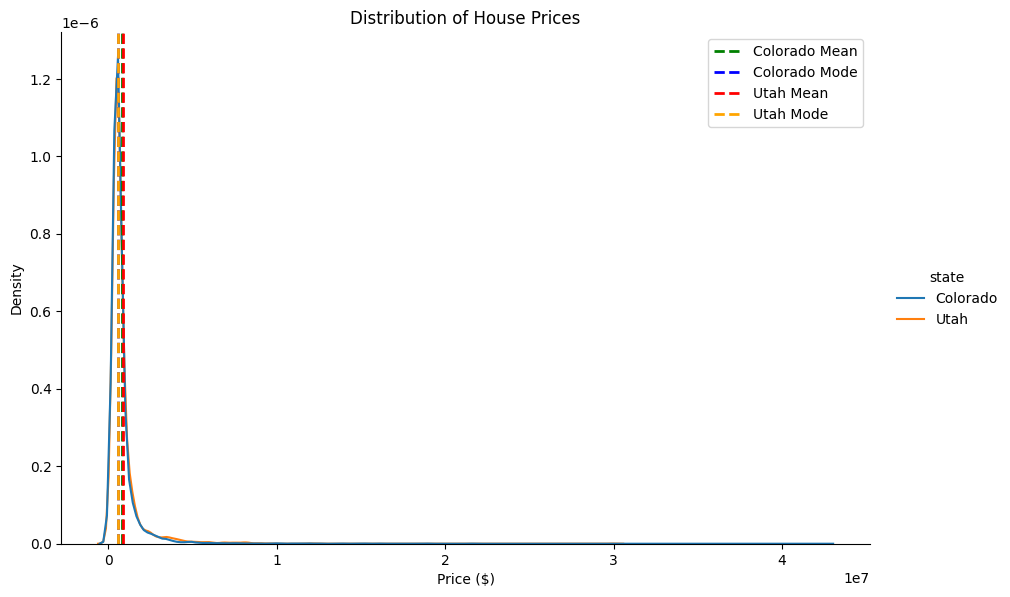

In [9]:
sns.displot(data=df, x='price', hue='state', kind='kde', common_norm=False, height=6, aspect=1.5)
plt.axvline(df[df.state == 'Colorado'].price.mean(), color='green', linestyle='dashed', linewidth=2, label='Colorado Mean')
plt.axvline(df[df.state == 'Colorado'].price.median(), color='blue', linestyle='dashed', linewidth=2, label='Colorado Mode')
plt.axvline(df[df.state == 'Utah'].price.mean(), color='red', linestyle='dashed', linewidth=2, label='Utah Mean')
plt.axvline(df[df.state == 'Utah'].price.median(), color='orange', linestyle='dashed', linewidth=2, label='Utah Mode')
plt.legend()
plt.title('Distribution of House Prices')
plt.xlabel('Price ($)')

Text(0.5, 9.444444444444459, 'Price ($)')

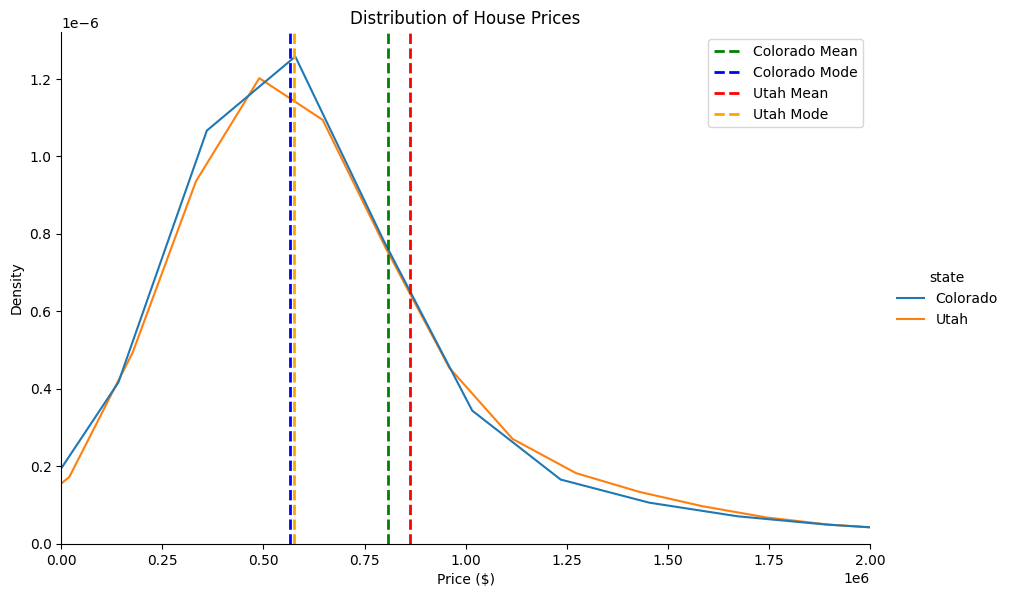

In [10]:
sns.displot(data=df, x='price', hue='state', kind='kde', common_norm=False, height=6, aspect=1.5)
plt.axvline(df[df.state == 'Colorado'].price.mean(), color='green', linestyle='dashed', linewidth=2, label='Colorado Mean')
plt.axvline(df[df.state == 'Colorado'].price.median(), color='blue', linestyle='dashed', linewidth=2, label='Colorado Mode')
plt.axvline(df[df.state == 'Utah'].price.mean(), color='red', linestyle='dashed', linewidth=2, label='Utah Mean')
plt.axvline(df[df.state == 'Utah'].price.median(), color='orange', linestyle='dashed', linewidth=2, label='Utah Mode')
plt.legend()
plt.xlim((0, 2000000))
plt.title('Distribution of House Prices')
plt.xlabel('Price ($)')

### Prepare the data for prediction

In [11]:
df['price_range'] = pd.qcut(df['price'], 4)
df['price_range_encoded'] = pd.qcut(df['price'], 4, labels=False)
df

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,price_range,price_range_encoded
0,886.0,for_sale,489900.0,3.0,3.0,0.05,869665.0,Centennial,Colorado,80122.0,2376.0,2002-09-09,"(430000.0, 565000.0]",1
1,79200.0,for_sale,300000.0,3.0,3.0,0.16,1218508.0,Burlington,Colorado,80807.0,1920.0,2018-05-15,"(11999.999, 430000.0]",0
2,86788.0,for_sale,96500.0,2.0,1.0,0.16,555775.0,Burlington,Colorado,80807.0,816.0,2013-02-22,"(11999.999, 430000.0]",0
3,86788.0,for_sale,129500.0,2.0,1.0,0.24,1103130.0,Burlington,Colorado,80807.0,1466.0,1990-04-04,"(11999.999, 430000.0]",0
4,86397.0,for_sale,155000.0,2.0,2.0,0.14,1383743.0,Wray,Colorado,80758.0,2126.0,2014-06-12,"(11999.999, 430000.0]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19360,33714.0,sold,409000.0,3.0,2.0,0.22,422210.0,Kanab,Utah,84741.0,1845.0,2021-12-30,"(11999.999, 430000.0]",0
19361,33714.0,sold,330000.0,3.0,2.0,0.21,422448.0,Kanab,Utah,84741.0,1254.0,2021-12-23,"(11999.999, 430000.0]",0
19362,33714.0,sold,390800.0,3.0,3.0,0.53,435240.0,Kanab,Utah,84741.0,1433.0,2021-12-03,"(11999.999, 430000.0]",0
19363,109914.0,sold,525000.0,3.0,3.0,0.99,80628.0,Toquerville,Utah,84774.0,1661.0,2021-11-12,"(430000.0, 565000.0]",1


In [12]:
df['utah'] = df.apply(lambda row: 1 if row.state == 'Utah' else 0, axis=1)
df

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,price_range,price_range_encoded,utah
0,886.0,for_sale,489900.0,3.0,3.0,0.05,869665.0,Centennial,Colorado,80122.0,2376.0,2002-09-09,"(430000.0, 565000.0]",1,0
1,79200.0,for_sale,300000.0,3.0,3.0,0.16,1218508.0,Burlington,Colorado,80807.0,1920.0,2018-05-15,"(11999.999, 430000.0]",0,0
2,86788.0,for_sale,96500.0,2.0,1.0,0.16,555775.0,Burlington,Colorado,80807.0,816.0,2013-02-22,"(11999.999, 430000.0]",0,0
3,86788.0,for_sale,129500.0,2.0,1.0,0.24,1103130.0,Burlington,Colorado,80807.0,1466.0,1990-04-04,"(11999.999, 430000.0]",0,0
4,86397.0,for_sale,155000.0,2.0,2.0,0.14,1383743.0,Wray,Colorado,80758.0,2126.0,2014-06-12,"(11999.999, 430000.0]",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19360,33714.0,sold,409000.0,3.0,2.0,0.22,422210.0,Kanab,Utah,84741.0,1845.0,2021-12-30,"(11999.999, 430000.0]",0,1
19361,33714.0,sold,330000.0,3.0,2.0,0.21,422448.0,Kanab,Utah,84741.0,1254.0,2021-12-23,"(11999.999, 430000.0]",0,1
19362,33714.0,sold,390800.0,3.0,3.0,0.53,435240.0,Kanab,Utah,84741.0,1433.0,2021-12-03,"(11999.999, 430000.0]",0,1
19363,109914.0,sold,525000.0,3.0,3.0,0.99,80628.0,Toquerville,Utah,84774.0,1661.0,2021-11-12,"(430000.0, 565000.0]",1,1


In [13]:
# df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'])
# df['days_since_last_sale'] = (pd.Timestamp.today() - df['prev_sold_date']).dt.days
# df

## Decision Trees

### Depth of 3

#### Training on whole dataset

In [14]:
# create a list of feature columns
feature_cols = ['bed', 'bath', 'acre_lot', 'house_size', 'utah',]# 'days_since_last_sale']

# define X and y
X = df[feature_cols]
y = df.price_range_encoded

# fit a classification tree on all data
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X.values, y)

dot = tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
                                    class_names=['0', '1', '2', '3'], filled = True)

# output dot code to copy/paste into https://dreampuf.github.io/GraphvizOnline
print(dot)

y_pred = treeclf.predict(X)

p,r,f,s = precision_recall_fscore_support(y, y_pred, labels=[0, 1, 2, 3])
display('precision = {}'.format(p))
display('recall = {}'.format(r))
display('f-score = {}'.format(f))

pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="house_size <= 3016.5\ngini = 0.75\nsamples = 19365\nvalue = [4844.0, 4852.0, 4877.0, 4792.0]\nclass = 2", fillcolor="#ffffff"] ;
1 [label="house_size <= 1613.5\ngini = 0.708\nsamples = 13162\nvalue = [4733, 4341, 2746, 1342]\nclass = 0", fillcolor="#fef9f6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="house_size <= 1153.5\ngini = 0.519\nsamples = 4432\nvalue = [2881.0, 986.0, 357.0, 208.0]\nclass = 0", fillcolor="#f1ba92"] ;
1 -> 2 ;
3 [label="gini = 0.411\nsamples = 1658\nvalue = [1244.0, 236.0, 115.0, 63.0]\nclass = 0", fillcolor="#eda673"] ;
2 -> 3 ;
4 [label="gini = 0.568\nsamples = 2774\nvalue = [1637.0, 750.0, 242.0, 145.0]\nclass = 0", fillcolor="#f4c8a8"] ;
2 -> 4 ;
5 [label="house_size <= 2152.5\ngini = 0.716\nsamples = 8730\nvalue = [1852.0, 3355.0, 2389.0, 1134.0]\nclass = 1", fillcolor="#e3fbe1"] ;
1 -> 5 ;
6 [label="gi

c:\Users\farns\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


'precision = [0.65004513 0.38430699 0.56408426 0.79952969]'

'recall = [0.5947564  0.69146744 0.32396965 0.56761269]'

'f-score = [0.62117292 0.49403622 0.41156551 0.66390041]'

,feature,importance
0,bed,0.000000
1,bath,0.000000
2,acre_lot,0.037471
3,house_size,0.962529
4,utah,0.000000


#### Monte Carlo cross-validation

In [15]:
# create a list of feature columns
feature_cols = ['bed', 'bath', 'acre_lot', 'house_size', 'utah',]# 'days_since_last_sale']

# define X and y
X = df[feature_cols]
y = df.price_range_encoded

scores = {'p': [], 'r': [], 'f': []}
for _ in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)#, random_state=42)

    # fit a classification tree on all data
    treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
    treeclf.fit(X_train, y_train)

    y_pred = treeclf.predict(X_test)

    p,r,f,s = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2, 3])
    scores['p'].append(p)
    scores['r'].append(r)
    scores['f'].append(f)

avgP = 0
for pre in scores['p']:
    avgP += pre
avgP /= len(scores['p'])

avgR = 0
for re in scores['r']:
    avgR += re
avgR /= len(scores['r'])

avgF = 0
for f in scores['f']:
    avgF += f
avgF /= len(scores['f'])

display('precision = {}'.format(avgP))
display('recall = {}'.format(avgR))
display('f-score = {}'.format(avgF))

'precision = [0.64876318 0.39283777 0.502139   0.8113592 ]'

'recall = [0.59645402 0.54522092 0.47016009 0.54018352]'

'f-score = [0.62135216 0.44264738 0.45856149 0.64802065]'

### Depth of 5

#### Training on whole dataset

In [16]:
# create a list of feature columns
feature_cols = ['bed', 'bath', 'acre_lot', 'house_size', 'utah',]# 'days_since_last_sale']

# define X and y
X = df[feature_cols]
y = df.price_range_encoded

# fit a classification tree on all data
treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)
treeclf.fit(X.values, y)

dot = tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
                                    class_names=['0', '1', '2', '3'], filled = True)

# output dot code to copy/paste into https://dreampuf.github.io/GraphvizOnline
print(dot)

y_pred = treeclf.predict(X)

p,r,f,s = precision_recall_fscore_support(y, y_pred, labels=[0, 1, 2, 3])
display('precision = {}'.format(p))
display('recall = {}'.format(r))
display('f-score = {}'.format(f))

pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="house_size <= 3016.5\ngini = 0.75\nsamples = 19365\nvalue = [4844.0, 4852.0, 4877.0, 4792.0]\nclass = 2", fillcolor="#ffffff"] ;
1 [label="house_size <= 1613.5\ngini = 0.708\nsamples = 13162\nvalue = [4733, 4341, 2746, 1342]\nclass = 0", fillcolor="#fef9f6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="house_size <= 1153.5\ngini = 0.519\nsamples = 4432\nvalue = [2881.0, 986.0, 357.0, 208.0]\nclass = 0", fillcolor="#f1ba92"] ;
1 -> 2 ;
3 [label="acre_lot <= 0.765\ngini = 0.411\nsamples = 1658\nvalue = [1244.0, 236.0, 115.0, 63.0]\nclass = 0", fillcolor="#eda673"] ;
2 -> 3 ;
4 [label="bath <= 1.5\ngini = 0.377\nsamples = 1495\nvalue = [1157, 213, 87, 38]\nclass = 0", fillcolor="#eca26d"] ;
3 -> 4 ;
5 [label="gini = 0.325\nsamples = 964\nvalue = [779, 139, 35, 11]\nclass = 0", fillcolor="#eb9d65"] ;
4 -> 5 ;
6 [label="gini = 0.462\nsam

c:\Users\farns\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


'precision = [0.61649812 0.41954023 0.56020605 0.76714432]'

'recall = [0.64182494 0.63190437 0.35677671 0.62562604]'

'f-score = [0.62890665 0.50427632 0.43592634 0.6891954 ]'

,feature,importance
0,bed,0.000880
1,bath,0.065093
2,acre_lot,0.082875
3,house_size,0.851152
4,utah,0.000000


#### Monte Carlo cross-validation

In [17]:
# create a list of feature columns
feature_cols = ['bed', 'bath', 'acre_lot', 'house_size', 'utah',]# 'days_since_last_sale']

# define X and y
X = df[feature_cols]
y = df.price_range_encoded

scores = {'p': [], 'r': [], 'f': []}
for _ in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)#, random_state=42)

    # fit a classification tree on all data
    treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)
    treeclf.fit(X_train, y_train)

    y_pred = treeclf.predict(X_test)

    p,r,f,s = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2, 3])
    scores['p'].append(p)
    scores['r'].append(r)
    scores['f'].append(f)

avgP = 0
for pre in scores['p']:
    avgP += pre
avgP /= len(scores['p'])

avgR = 0
for re in scores['r']:
    avgR += re
avgR /= len(scores['r'])

avgF = 0
for f in scores['f']:
    avgF += f
avgF /= len(scores['f'])

display('precision = {}'.format(avgP))
display('recall = {}'.format(avgR))
display('f-score = {}'.format(avgF))

'precision = [0.62078258 0.42576537 0.50455775 0.77300551]'

'recall = [0.62861343 0.56860094 0.4329415  0.59821494]'

'f-score = [0.62428611 0.48288269 0.45922774 0.67371113]'

### Testing the most important feature only

In [18]:
# create a list of feature columns
feature_cols = ['house_size']

# define X and y
X = df[feature_cols]
y = df.price_range_encoded

# fit a classification tree on all data
treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)
treeclf.fit(X.values, y)

dot = tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
                                    class_names=['0', '1', '2', '3'], filled = True)

# output dot code to copy/paste into https://dreampuf.github.io/GraphvizOnline
print(dot)

y_pred = treeclf.predict(X)

p,r,f,s = precision_recall_fscore_support(y, y_pred, labels=[0, 1, 2, 3])
display('precision = {}'.format(p))
display('recall = {}'.format(r))
display('f-score = {}'.format(f))

digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="house_size <= 3016.5\ngini = 0.75\nsamples = 19365\nvalue = [4844.0, 4852.0, 4877.0, 4792.0]\nclass = 2", fillcolor="#ffffff"] ;
1 [label="house_size <= 1613.5\ngini = 0.708\nsamples = 13162\nvalue = [4733, 4341, 2746, 1342]\nclass = 0", fillcolor="#fef9f6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="house_size <= 1153.5\ngini = 0.519\nsamples = 4432\nvalue = [2881.0, 986.0, 357.0, 208.0]\nclass = 0", fillcolor="#f1ba92"] ;
1 -> 2 ;
3 [label="house_size <= 704.5\ngini = 0.411\nsamples = 1658\nvalue = [1244.0, 236.0, 115.0, 63.0]\nclass = 0", fillcolor="#eda673"] ;
2 -> 3 ;
4 [label="house_size <= 551.0\ngini = 0.18\nsamples = 165\nvalue = [149, 10, 6, 0]\nclass = 0", fillcolor="#e88e4d"] ;
3 -> 4 ;
5 [label="gini = 0.043\nsamples = 45\nvalue = [44, 0, 1, 0]\nclass = 0", fillcolor="#e6843d"] ;
4 -> 5 ;
6 [label="gini = 0.226\nsampl

c:\Users\farns\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


'precision = [0.61570167 0.40610764 0.4570753  0.83022847]'

'recall = [0.64760528 0.49608409 0.51527578 0.49290484]'

'f-score = [0.63125063 0.44660915 0.48443373 0.6185675 ]'

In [19]:
# create a list of feature columns
feature_cols = ['house_size']

# define X and y
X = df[feature_cols]
y = df.price_range_encoded

# fit a classification tree on all data
treeclf = DecisionTreeClassifier(max_depth=4, random_state=1)
treeclf.fit(X.values, y)

dot = tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
                                    class_names=['0', '1', '2', '3'], filled = True)

# output dot code to copy/paste into https://dreampuf.github.io/GraphvizOnline
print(dot)

y_pred = treeclf.predict(X)

p,r,f,s = precision_recall_fscore_support(y, y_pred, labels=[0, 1, 2, 3])
display('precision = {}'.format(p))
display('recall = {}'.format(r))
display('f-score = {}'.format(f))

digraph Tree {
node [shape=box, style="filled", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="house_size <= 3016.5\ngini = 0.75\nsamples = 19365\nvalue = [4844.0, 4852.0, 4877.0, 4792.0]\nclass = 2", fillcolor="#ffffff"] ;
1 [label="house_size <= 1613.5\ngini = 0.708\nsamples = 13162\nvalue = [4733, 4341, 2746, 1342]\nclass = 0", fillcolor="#fef9f6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="house_size <= 1153.5\ngini = 0.519\nsamples = 4432\nvalue = [2881.0, 986.0, 357.0, 208.0]\nclass = 0", fillcolor="#f1ba92"] ;
1 -> 2 ;
3 [label="house_size <= 704.5\ngini = 0.411\nsamples = 1658\nvalue = [1244.0, 236.0, 115.0, 63.0]\nclass = 0", fillcolor="#eda673"] ;
2 -> 3 ;
4 [label="gini = 0.18\nsamples = 165\nvalue = [149, 10, 6, 0]\nclass = 0", fillcolor="#e88e4d"] ;
3 -> 4 ;
5 [label="gini = 0.432\nsamples = 1493\nvalue = [1095, 226, 109, 63]\nclass = 0", fillcolor="#eda977"] ;
3 -> 5 ;
6 [label="house_size <= 1450.5\ngini = 0.

c:\Users\farns\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


'precision = [0.65004513 0.40121581 0.45302365 0.75293788]'

'recall = [0.5947564  0.54410552 0.44392044 0.56156093]'

'f-score = [0.62117292 0.46186144 0.44842585 0.64331819]'

### Finding the best depth

In [20]:
fScores = {
    'depth': [],
    '0': [],
    '1': [],
    '2': [],
    '3': [],
    'avg': []
}
for i in range(2, 21):   
    # create a list of feature columns
    feature_cols = ['bed', 'bath', 'acre_lot', 'house_size', 'utah',]# 'days_since_last_sale']

    # define X and y
    X = df[feature_cols]
    y = df.price_range_encoded

    scores = {'p': [], 'r': [], 'f': []}
    for _ in range(30):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)#, random_state=42)

        # fit a classification tree on all data
        treeclf = DecisionTreeClassifier(max_depth=i, random_state=1)
        treeclf.fit(X_train, y_train)

        y_pred = treeclf.predict(X_test)

        p,r,f,s = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2, 3])
        scores['f'].append(f)

    avgF = 0
    for f in scores['f']:
        avgF += f
    avgF /= len(scores['f'])

    fScores['depth'].append(i)
    fScores['0'].append(avgF[0])
    fScores['1'].append(avgF[1])
    fScores['2'].append(avgF[2])
    fScores['3'].append(avgF[3])
    fScores['avg'].append((avgF[0] + avgF[1] + avgF[2] + avgF[3]) / 4)

display(fScores)

{'depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 '0': [0.6194053262716276,
  0.6189014248792958,
  0.6197569758287507,
  0.623039521834375,
  0.6343731126341966,
  0.6327512762898374,
  0.6284809614738922,
  0.6257834859330835,
  0.6221922971755364,
  0.6157563854193498,
  0.6096344754532482,
  0.6044485771415739,
  0.5972188199308239,
  0.5955126655260521,
  0.5901020430821853,
  0.5810380638458906,
  0.5789751068439117,
  0.5745584734873977,
  0.574767245331889],
 '1': [0.48824439489035093,
  0.43218321120627673,
  0.4719273461738138,
  0.4816535167825514,
  0.4954489002476335,
  0.48438720584640227,
  0.5001983574156617,
  0.48896452279650116,
  0.49096920689132134,
  0.4831890206638153,
  0.4766890001167073,
  0.47420748848836747,
  0.4704736683751671,
  0.4639552078250316,
  0.45883855974680976,
  0.457453194098699,
  0.45028268700756474,
  0.44786689244667227,
  0.4472332685268016],
 '2': [0.4060533205429083,
  0.46570120570017537,
  0.409857365591

In [21]:
scoresDF = pd.DataFrame(fScores)
scoresDF = pd.melt(scoresDF, id_vars='depth', value_vars=['0', '1', '2', '3', 'avg'],
                    var_name='class', value_name='fScore')
scoresDF

,depth,class,fScore
0,2,0,0.619405
1,3,0,0.618901
2,4,0,0.619757
3,5,0,0.623040
4,6,0,0.634373
...,...,...,...
90,16,avg,0.537242
91,17,avg,0.534068
92,18,avg,0.530960
93,19,avg,0.526652


In [22]:
maxAvgScore = scoresDF[scoresDF['class'] == 'avg']['fScore'].max()
display(maxAvgScore)
bestDepth = scoresDF[scoresDF['class'] == 'avg'][scoresDF['fScore'] == maxAvgScore].depth.tolist()[0]
display(bestDepth)
index = fScores['depth'].index(7)
bestDepthScores = {}
for key, value in fScores.items():
    if not key in ['depth', 'avg']:
        bestDepthScores[key] = value[index]
bestDepthScores

0.5752071570085067

C:\Users\farns\AppData\Local\Temp\ipykernel_12052\875857880.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bestDepth = scoresDF[scoresDF['class'] == 'avg'][scoresDF['fScore'] == maxAvgScore].depth.tolist()[0]


8

{'0': 0.6327512762898374,
 '1': 0.48438720584640227,
 '2': 0.4806178215994689,
 '3': 0.6969227472365243}

Text(0, 0.5, 'Average F-Score')

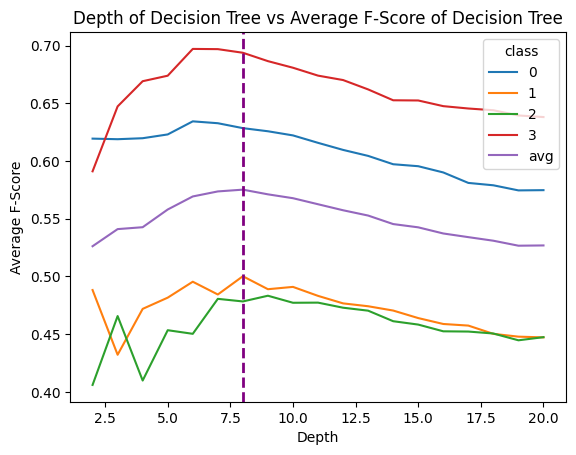

In [23]:
sns.lineplot(data=scoresDF, x='depth', y='fScore', hue='class')
plt.axvline(bestDepth, color='purple', linestyle='dashed', linewidth=2, label='Best Depth')
plt.title('Depth of Decision Tree vs Average F-Score of Decision Tree')
plt.xlabel('Depth')
plt.ylabel('Average F-Score')

It looks like a depth of 7 is the best generally.

## Neural Networks

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [25]:
display(df)
df.describe

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,price_range,price_range_encoded,utah
0,886.0,for_sale,489900.0,3.0,3.0,0.05,869665.0,Centennial,Colorado,80122.0,2376.0,2002-09-09,"(430000.0, 565000.0]",1,0
1,79200.0,for_sale,300000.0,3.0,3.0,0.16,1218508.0,Burlington,Colorado,80807.0,1920.0,2018-05-15,"(11999.999, 430000.0]",0,0
2,86788.0,for_sale,96500.0,2.0,1.0,0.16,555775.0,Burlington,Colorado,80807.0,816.0,2013-02-22,"(11999.999, 430000.0]",0,0
3,86788.0,for_sale,129500.0,2.0,1.0,0.24,1103130.0,Burlington,Colorado,80807.0,1466.0,1990-04-04,"(11999.999, 430000.0]",0,0
4,86397.0,for_sale,155000.0,2.0,2.0,0.14,1383743.0,Wray,Colorado,80758.0,2126.0,2014-06-12,"(11999.999, 430000.0]",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19360,33714.0,sold,409000.0,3.0,2.0,0.22,422210.0,Kanab,Utah,84741.0,1845.0,2021-12-30,"(11999.999, 430000.0]",0,1
19361,33714.0,sold,330000.0,3.0,2.0,0.21,422448.0,Kanab,Utah,84741.0,1254.0,2021-12-23,"(11999.999, 430000.0]",0,1
19362,33714.0,sold,390800.0,3.0,3.0,0.53,435240.0,Kanab,Utah,84741.0,1433.0,2021-12-03,"(11999.999, 430000.0]",0,1
19363,109914.0,sold,525000.0,3.0,3.0,0.99,80628.0,Toquerville,Utah,84774.0,1661.0,2021-11-12,"(430000.0, 565000.0]",1,1


<bound method NDFrame.describe of        brokered_by    status     price  bed  bath  acre_lot     street  \
0            886.0  for_sale  489900.0  3.0   3.0      0.05   869665.0   
1          79200.0  for_sale  300000.0  3.0   3.0      0.16  1218508.0   
2          86788.0  for_sale   96500.0  2.0   1.0      0.16   555775.0   
3          86788.0  for_sale  129500.0  2.0   1.0      0.24  1103130.0   
4          86397.0  for_sale  155000.0  2.0   2.0      0.14  1383743.0   
...            ...       ...       ...  ...   ...       ...        ...   
19360      33714.0      sold  409000.0  3.0   2.0      0.22   422210.0   
19361      33714.0      sold  330000.0  3.0   2.0      0.21   422448.0   
19362      33714.0      sold  390800.0  3.0   3.0      0.53   435240.0   
19363     109914.0      sold  525000.0  3.0   3.0      0.99    80628.0   
19364     109914.0      sold  345000.0  3.0   2.0      0.53   860229.0   

              city     state  zip_code  house_size prev_sold_date  \
0       

In [26]:
# create a list of feature columns
feature_cols = ['bed', 'bath', 'acre_lot', 'house_size', 'utah',]# 'days_since_last_sale']
# Tried with added features 'zip_code','brokered_by', 'status', was not better. Most predictions were worst. 

# define X and y
X = df[feature_cols]
y = df.price_range_encoded


In [27]:
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[ 2.20372454e-01,  8.41612902e-01, -2.50531588e-02,
         2.34151700e+00, -5.21157307e-01],
       [-4.86288874e-01, -7.06059675e-01, -2.67839852e-02,
        -5.82387262e-01, -5.21157307e-01],
       [ 9.27033782e-01,  2.38928548e+00, -8.48667785e-03,
         2.36743240e+00, -5.21157307e-01],
       ...,
       [ 2.20372454e-01,  8.41612902e-01, -2.71548766e-02,
        -1.88244828e-03,  1.91880645e+00],
       [-4.86288874e-01, -7.06059675e-01, -2.67839852e-02,
        -7.46950010e-01, -5.21157307e-01],
       [ 2.20372454e-01,  6.77766136e-02, -2.65367243e-02,
        -1.47008652e-01, -5.21157307e-01]])

In [28]:
# mlp = MLPClassifier(hidden_layer_sizes=(3),max_iter=500)
mlp = MLPClassifier(hidden_layer_sizes=(7, 9, 11),max_iter=50000)
mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(7, 9, 11), max_iter=50000)

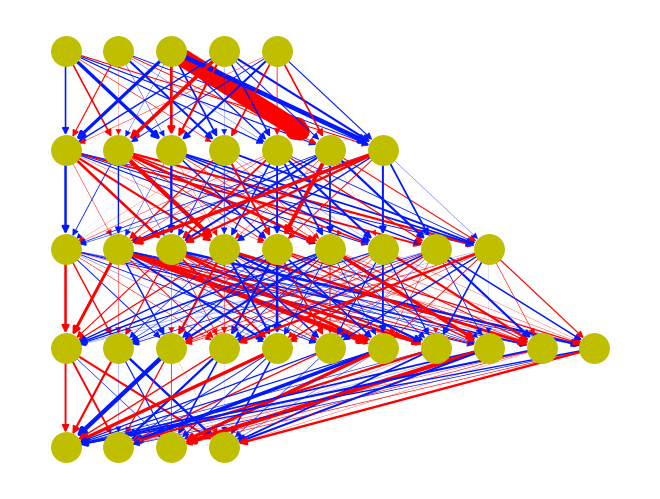

In [29]:
import networkx as nx
import colorsys

def show_ann(mlp):
    hidden_layers_n = len(mlp.coefs_)-1
    layers_n = hidden_layers_n + 2
    input_neurons_n = len(mlp.coefs_[0])
    hidden_neurons_n = [len(mlp.coefs_[i+1]) for i in range(hidden_layers_n)]
    output_neurons_n = len(mlp.coefs_[-1][0])

    G = nx.DiGraph()
    pos = {}

    # Create the neurons of the input layer
    for i in range(input_neurons_n):
        pos['Layer0_{}'.format(i)] = (i,layers_n-1)

    for j in range(hidden_layers_n):
        # Create the neurons of the j'th hidden layer
        prev_layer = j
        cur_layer = j+1
        if (j == 0):
            prev_size = input_neurons_n
        else:
            prev_size = hidden_neurons_n[j-1]
        for i in range(hidden_neurons_n[j]):
            pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
            for k in range(prev_size):
                w = mlp.coefs_[prev_layer][k][i]
                G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    # Create the neurons of the output layer
    prev_layer = hidden_layers_n
    cur_layer = hidden_layers_n+1
    for i in range(output_neurons_n):
        pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
        for k in range(hidden_neurons_n[-1]):
            w = mlp.coefs_[prev_layer][k][i]
            G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    edges = G.edges()
    colors = [colorsys.hsv_to_rgb(0 if G[u][v]['weight'] < 0 else 0.65,
                                  1,#min(1, abs(G[u][v]['weight'])),
                                  1) for u,v in edges]
    weights = [abs(G[u][v]['weight'])*2 for u,v in edges]

    nx.draw(G, pos, node_color='y', node_size=450, width=weights, edge_color=colors)
    
show_ann(mlp)

In [30]:
# mlp = MLPClassifier(hidden_layer_sizes=(4),max_iter=500)
mlp = MLPClassifier(hidden_layer_sizes=(9, 5, 7, 10),max_iter=50000)
mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(9, 5, 7, 10), max_iter=50000)

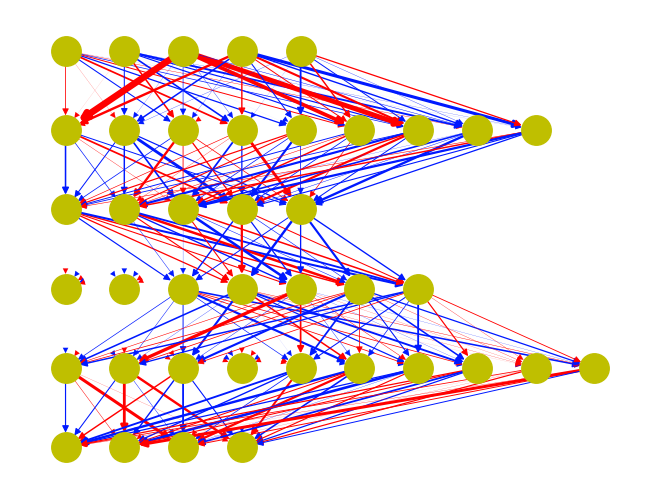

In [31]:
def show_ann(mlp):
    hidden_layers_n = len(mlp.coefs_)-1
    layers_n = hidden_layers_n + 2
    input_neurons_n = len(mlp.coefs_[0])
    hidden_neurons_n = [len(mlp.coefs_[i+1]) for i in range(hidden_layers_n)]
    output_neurons_n = len(mlp.coefs_[-1][0])

    G = nx.DiGraph()
    pos = {}

    # Create the neurons of the input layer
    for i in range(input_neurons_n):
        pos['Layer0_{}'.format(i)] = (i,layers_n-1)

    for j in range(hidden_layers_n):
        # Create the neurons of the j'th hidden layer
        prev_layer = j
        cur_layer = j+1
        if (j == 0):
            prev_size = input_neurons_n
        else:
            prev_size = hidden_neurons_n[j-1]
        for i in range(hidden_neurons_n[j]):
            pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
            for k in range(prev_size):
                w = mlp.coefs_[prev_layer][k][i]
                G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    # Create the neurons of the output layer
    prev_layer = hidden_layers_n
    cur_layer = hidden_layers_n+1
    for i in range(output_neurons_n):
        pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
        for k in range(hidden_neurons_n[-1]):
            w = mlp.coefs_[prev_layer][k][i]
            G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    edges = G.edges()
    colors = [colorsys.hsv_to_rgb(0 if G[u][v]['weight'] < 0 else 0.65,
                                  1,#min(1, abs(G[u][v]['weight'])),
                                  1) for u,v in edges]
    weights = [abs(G[u][v]['weight'])*2 for u,v in edges]

    nx.draw(G, pos, node_color='y', node_size=450, width=weights, edge_color=colors)
    
show_ann(mlp)

In [32]:
# mlp = MLPClassifier(hidden_layer_sizes=(6),max_iter=500)
mlp = MLPClassifier(hidden_layer_sizes=(5, 11, 9, 7, 6, 10),max_iter=50000)
mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(5, 11, 9, 7, 6, 10), max_iter=50000)

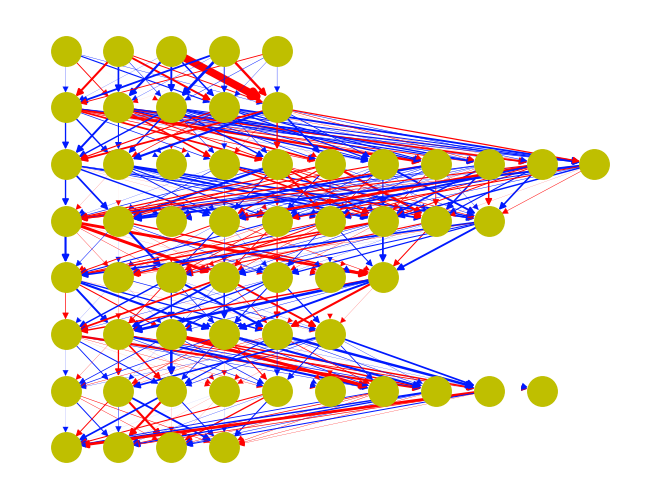

In [33]:
def show_ann(mlp):
    hidden_layers_n = len(mlp.coefs_)-1
    layers_n = hidden_layers_n + 2
    input_neurons_n = len(mlp.coefs_[0])
    hidden_neurons_n = [len(mlp.coefs_[i+1]) for i in range(hidden_layers_n)]
    output_neurons_n = len(mlp.coefs_[-1][0])

    G = nx.DiGraph()
    pos = {}

    # Create the neurons of the input layer
    for i in range(input_neurons_n):
        pos['Layer0_{}'.format(i)] = (i,layers_n-1)

    for j in range(hidden_layers_n):
        # Create the neurons of the j'th hidden layer
        prev_layer = j
        cur_layer = j+1
        if (j == 0):
            prev_size = input_neurons_n
        else:
            prev_size = hidden_neurons_n[j-1]
        for i in range(hidden_neurons_n[j]):
            pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
            for k in range(prev_size):
                w = mlp.coefs_[prev_layer][k][i]
                G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    # Create the neurons of the output layer
    prev_layer = hidden_layers_n
    cur_layer = hidden_layers_n+1
    for i in range(output_neurons_n):
        pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
        for k in range(hidden_neurons_n[-1]):
            w = mlp.coefs_[prev_layer][k][i]
            G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    edges = G.edges()
    colors = [colorsys.hsv_to_rgb(0 if G[u][v]['weight'] < 0 else 0.65,
                                  1,#min(1, abs(G[u][v]['weight'])),
                                  1) for u,v in edges]
    weights = [abs(G[u][v]['weight'])*2 for u,v in edges]

    nx.draw(G, pos, node_color='y', node_size=450, width=weights, edge_color=colors)
    
show_ann(mlp)